# Pokémon Changes Through the Generations


In [2]:
import csv
import kaggle
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Initialize dictionary for generations
gen_weights = {str(i): [] for i in range(1, 8)}

# Read CSV and populate generation lists
with open('pokemon.csv', newline='') as data:
    reader = csv.DictReader(data)
    for row in reader:
        gen = row['generation']
        if gen in gen_weights and row['weight_kg']:
            gen_weights[gen].append(float(row['weight_kg']))




## Average weight

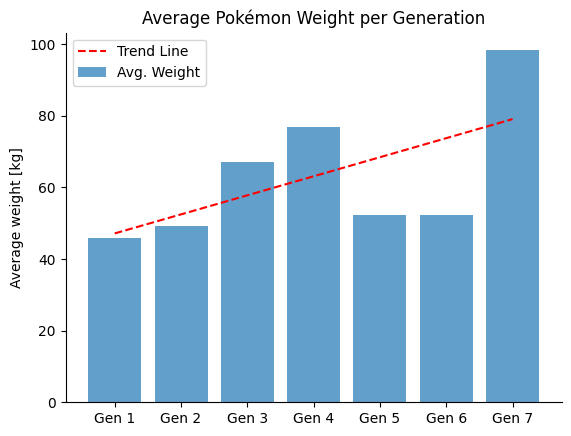

In [25]:
# Function to compute mean
def find_mean(lst):
    return sum(lst) / len(lst)

# Compute mean weights og the different generations
x_vals = np.arange(1, 8)
means = [find_mean(gen_weights[str(i)]) for i in range(1, 8)]

# Fit a linear trend line
coeffs = np.polyfit(x_vals, means, 1)  # Find a fitting linear polynomial and return the coefficients
trend_line = np.poly1d(coeffs)  # Create the polynomial function

# Create x and y values for the plotting of the trend line
x_trend = np.linspace(1, 7, 100)
y_trend = trend_line(x_trend)

# Plot trend line
plt.plot(x_trend, y_trend, color='red', linestyle='--', label="Trend Line")

# Create bar plot of the avg. weights 
plt.bar(x_vals, means, tick_label=[f'Gen {i}' for i in range(1, 8)], alpha=0.7, label="Avg. Weight")

# Labels and title
plt.ylabel("Average weight [kg]")
# plt.xlabel("Different generations")
plt.title("Average Pokémon Weight per Generation")

# Some custumization 
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
plt.show()



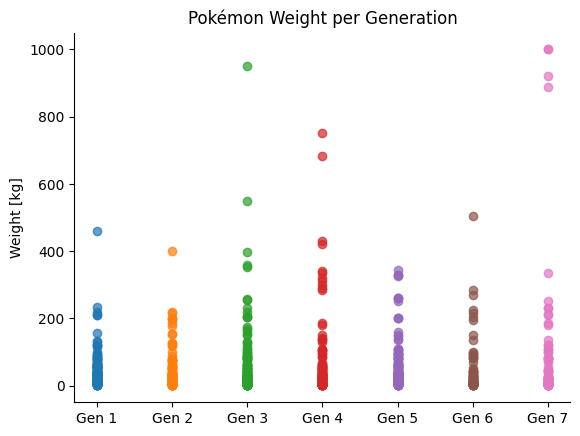

In [33]:
for i in range(1, 8):
    plt.scatter([f'Gen {i}' for j in range(len(gen_weights[str(i)]))], gen_weights[str(i)], alpha=0.7) 
    

# Some custumization 
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel("Weight [kg]")
plt.title("Pokémon Weight per Generation")

# plt.legend()
plt.show()

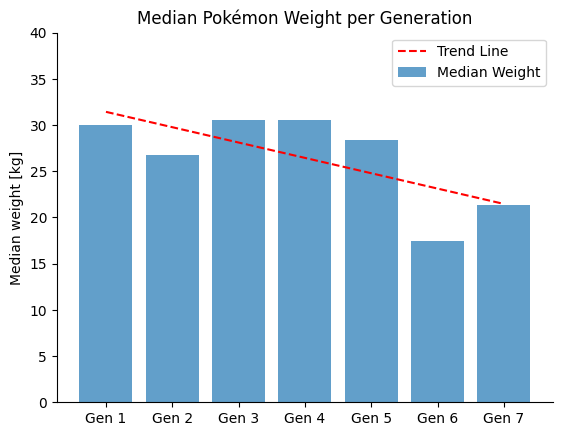

In [37]:
# Calculate the median value depending on wheather the list is odd or even
def find_median(lst):
    if len(lst)%2 == 1:
        lst.sort() # The original list is not sorted making the implemented method not find the correct median
        median = lst[round(len(lst) / 2)]
    elif len(lst)%2 == 0:
        lst.sort()
        median = (lst[int(len(lst) / 2)] + lst[int(len(lst) / 2) - 1]) / 2 # If there is no singular median, the avergave of the two median values are used
    return median


# Compute medial weights og the different generations
x_vals = np.arange(1, 8)
medians = [find_median(gen_weights[str(i)]) for i in range(1, 8)]

# Fit a linear trend line
coeffs = np.polyfit(x_vals, medians, 1)  # Find a fitting linear polynomial and return the coefficients
trend_line = np.poly1d(coeffs)  # Create the polynomial function

# Create x and y values for the plotting of the trend line
x_trend = np.linspace(1, 7, 100)
y_trend = trend_line(x_trend)

# Plot trend line
plt.plot(x_trend, y_trend, color='red', linestyle='--', label="Trend Line")

# Create bar plot of the median weights 
plt.bar(x_vals, medians, tick_label=[f'Gen {i}' for i in range(1, 8)], alpha=0.7, label="Median Weight")


# Some custumization 
plt.ylabel("Median weight [kg]")
plt.title("Median Pokémon Weight per Generation")
plt.ylim([0, 40])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
plt.show()

# Something is wrong here ....

Look at median, scatter everything, type number (ranges)

## Gender ratios

## Average HP

## Pokémon happines